<a href="https://colab.research.google.com/github/mgczacki/iap/blob/master/libretas/Tarea3-Ej1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Localización empleando transferencia

Curso: [Introducción al Aprendizaje Profundo](http://turing.iimas.unam.mx/~ricardoml/course/iap/). Profesores: [Bere](https://turing.iimas.unam.mx/~bereml/) y [Ricardo](https://turing.iimas.unam.mx/~ricardoml/) Montalvo Lezama.

---
---

Resuelve los siguientes ejercicios en libretas de Colab independientes que sean replicables.

# 1. Entrena modelos de regresión para predecir edades en el conjunto de datos UTKFace. La solución debe cumplir con los siguientes puntos:

- Implementa la tubería de datos usando el conjunto de rostros alineados y recortados.
- Agrega acrecentamiento de datos usando un espejeo horizontal.
- Particiona aleatoriamente en subconjuntos entrenamiento $80\%$ y prueba $20\%$.
- Usando transferencia de conocimiento, entrena un modelo reentrenando solo la última capa.
- Usando transferencia de conocimiento, entrena un modelo reentrenando toda la red.
- Discute el comportamiento de los modelos durante el entrenamiento y los resultados finales en ambos conjuntos.

### 1.1 Bibliotecas

In [1]:
# Colab
! pip install torchinfo

In [2]:
# funciones aleatorias
import random
# sistema de archivos
import os
# flush!
import sys
# procesamiento xml
import xml.etree.ElementTree as ET
# sistema de archivos
from os.path import join

# gráficas
import matplotlib.patches as patches
import matplotlib.pyplot as plt
# arreglos multidimensionales
import numpy as np
# redes neuronales
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.datasets.utils as tvu
import torchvision.models as tvm
import torchvision.transforms as T
from scipy.io import loadmat
from torch.utils.data import DataLoader, random_split
# from torchvision.datasets import VisionDataset 
# inspección de arquitectura
from torchinfo import summary
# barras de progreso
from tqdm import tqdm
# imágenes
from PIL import Image

#regex
import re

### 1.2 Utilerias

In [3]:
# directorio de datos
DATA_DIR = ''

# tamaño del lote
BATCH_SIZE = 64
# tamaño de la imagen
IMG_SIZE = 200

# filas y columnas de la cuadrícula 
ROWS, COLS = 4, 8

# media y varianza de de ImageNet
IMAGENET_MEAN = [0.485, 0.456, 0.406]
IMAGENET_STD = [0.229, 0.224, 0.225]


def display_grid(rows, cols, xs, y_true, y_pred=None, figsize=(14, 7)):
    """Despliega ejemplos en una cuadrícula."""
    fig, ax = plt.subplots(rows, cols, figsize=figsize)
    i = 0
    for r in range(rows):
        for c in range(cols):
            img = xs[i]
            ax[r, c].imshow(xs[i], cmap='gray')
            ax[r, c].set_xticklabels([])
            ax[r, c].set_yticklabels([])
            tstring = "Real: " + str(y_true[i])
            if y_pred is not None:
                tstring = tstring + "\nPred:" + str(y_pred[i])
            ax[r, c].set_title(tstring)
            i += 1
    fig.tight_layout()
    plt.show()


def display_batch(rows, cols, x, y_true, y_pred=None, figsize=(14, 7)):
    """Despliega un lote en una cuadrícula."""
    # denormalizamos
    for c, (mean, std) in enumerate(zip(IMAGENET_MEAN, IMAGENET_STD)):
        x[:, c] = x[:, c] * std + mean 
    x *= 255
    # rotamos canales
    x = x.permute(0, 2, 3, 1)
    # convertimos a entero
    x = (x.numpy()).astype(np.uint8)

    y_true = y_true.numpy().astype(np.uint8)
    if y_pred is not None:
        y_pred = y_pred.numpy().astype(np.uint8)
    display_grid(rows, cols, x, y_true, y_pred, figsize=figsize)


def set_seed(seed=0):
    """Initializes pseudo-random number generators."""
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)


# reproducibilidad
set_seed()

### Uso del GPU

In [4]:
# obtenemos dispositivo en gpu, si no en cpu
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

## 2 Datos

### 2.1 Conjunto de datos

In [5]:
def get_age(x):
    return float(re.findall("^[0-9]+", x)[0])

# basado en https://github.com/pytorch/vision/blob/master/torchvision/datasets/caltech.py 
class UTKFaces:

    def __init__(self, root, transform, section = 'trn', trn_portion = .8, download=False, seed = 30):
        self.root = join(root, 'UTKFace')
        self.transform = transform
        self.section = section
        self.trn_portion = trn_portion
        self.seed = seed
        
        os.makedirs(self.root, exist_ok=True)

        if download:
            self.download()

        if not self._check_integrity():
            raise RuntimeError(
                'Dataset not found or corrupted.' +
                ' You can use download=True to download it')
        
        # guardamos filenames
        self.filenames = os.listdir(self.root)
        
        # random shuffle
        random.Random(seed).shuffle(self.filenames)
        
        # seccionamos
        if(section == 'trn'):
            self.filenames = self.filenames[0:int(len(self.filenames)*trn_portion)]
        elif (section == "tst"):
            self.filenames = self.filenames[int(len(self.filenames)*trn_portion):-1]
            
        # leemos edades
        self.ages = list(map(get_age, self.filenames))

    def __getitem__(self, index):
        img = Image.open(join(
            self.root,                  
            self.filenames[index])
        )
        # si la imagen es escala de grises
        # transformamos a RGB
        if img.mode == 'L':
            rgbimg = Image.new('RGB', img.size)
            rgbimg.paste(img)
            img = rgbimg

        if self.transform is not None:
            img = self.transform(img)

        return img, self.ages[index]

    def __len__(self):
        return len(self.ages)
    
    def _check_integrity(self):
        return os.path.exists(self.root)

    def download(self):
        if self._check_integrity():
            print('Files already downloaded and verified')
            return
        tvu.download_and_extract_archive(
            url='https://cloud.xibalba.com.mx/s/QpJdJ5aLEDG9Ryb',
            download_root=self.root,
            filename='UTKFace.tar.gz',
            md5=''
        )

### 2.2 Transformación

In [6]:
class Rescale:

    def __init__(self, size, img_tsfm):
        self.size = size
        self.img_tsfm = img_tsfm

    # hace el objeto llamable, 
    # se comporta como una una función
    def __call__(self, img):
        # obtenemos las dimensiones originales
        img = self.img_tsfm(img)
    
        return img

### 2.3 Instancia del conjunto y partición

In [7]:
# transofrmación de la imagen
img_trn_tsfm = T.Compose([
    # redimensionamos a 224x224
    T.Resize([IMG_SIZE, IMG_SIZE]),
    
    #Espejeo horizontal aleatorio
    T.RandomHorizontalFlip(),
    
    # convertimos a torch.Tensor [3,H,W]
    # y escalamos a [0,1]
    T.ToTensor(),
    # estandarizamos con media y varianza
    T.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD)
])

img_tst_tsfm = T.Compose([
    # redimensionamos a 224x224
    T.Resize([IMG_SIZE, IMG_SIZE]),
    # convertimos a torch.Tensor [3,H,W]
    # y escalamos a [0,1]
    T.ToTensor(),
    # estandarizamos con media y varianza
    T.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD)
])

# transformación conjunta del ejemplo
trn_tsfm = Rescale(IMG_SIZE, img_trn_tsfm)
tst_tsfm = Rescale(IMG_SIZE, img_tst_tsfm)


trn_ds = UTKFaces(DATA_DIR, trn_tsfm, section = 'trn', download=True)
tst_ds = UTKFaces(DATA_DIR, tst_tsfm, section = 'tst', download=True)

len(trn_ds), len(tst_ds)

Files already downloaded and verified
Files already downloaded and verified


(18966, 4741)

### 2.4 Cargadores de datos

In [8]:
trn_dl = DataLoader(
    # conjunto
    trn_ds,
    # tamaño del lote
    batch_size=BATCH_SIZE,
    # desordenar
    shuffle=True,
    # 4 procesos paralelos
    num_workers=4
)
tst_dl = DataLoader(
    # conjunto
    tst_ds,
    # tamaño del lote
    batch_size=BATCH_SIZE,
    # 4 procesos paralelos
    num_workers=4
)

x shape=torch.Size([64, 3, 200, 200]) dtype=torch.float32
y shape=torch.Size([64]) dtype=torch.float64


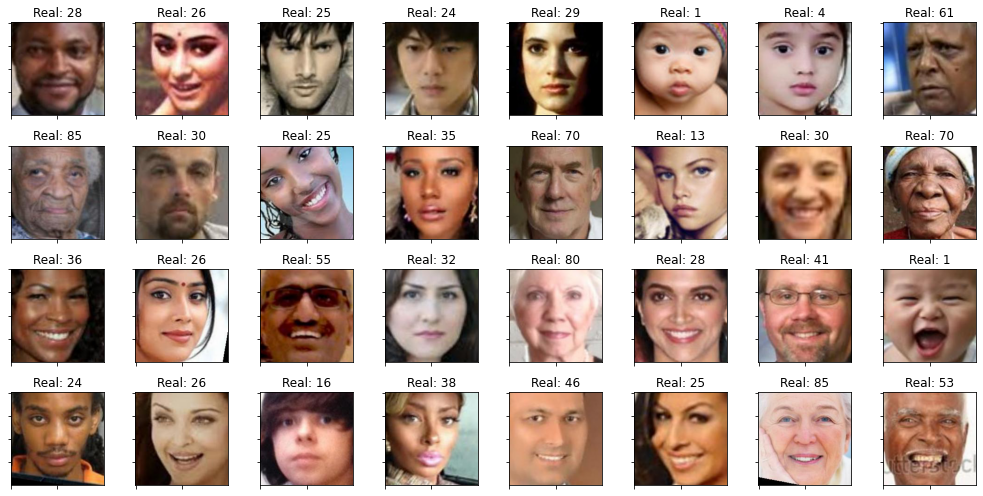

In [9]:
x, y = next(iter(trn_dl))
print(f'x shape={x.shape} dtype={x.dtype}')
print(f'y shape={y.shape} dtype={y.dtype}')
display_batch(ROWS, COLS, x, y)

## 3 Modelo

Torchvision provee una familia de [modelos](https://pytorch.org/docs/1.6.0/torchvision/models.html#classification) preentrenados en ImageNet. Usaremos [Shufflenet V2](https://arxiv.org/abs/1807.11164), una arquitectura eficiente para clasificación de imágenes. 

In [9]:
tvm.densenet121()

DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu

### 3.1 Carga de pesos y transferencia

In [10]:
class RegDenseNet(nn.Module):
    
    def __init__(self, pretrained):
        super(RegDenseNet, self).__init__()
        
        # cargamos el modelo
        self.cnn = tvm.densenet121(pretrained=pretrained)
        # remplazamos la FC para dejar intactas 
        # las características (diablito)
        self.cnn.classifier = nn.Identity()

        in_features = 1024
        # armamos la capa de regresión
        self.reg = nn.Sequential(
            nn.BatchNorm1d(in_features),
            nn.Linear(in_features, 1)
        )
    
    def forward(self, x):
        # [N, 3, 224, 224] => [N, 1024]
        x = self.cnn(x)
        # [N, 1024] => [N, 1]
        x = self.reg(x)
        return torch.squeeze(x)

In [ ]:
model = RegDenseNet(True)

# congelado de parámetros de la CNN
for param in model.cnn.parameters():
    param.requires_grad = False
# congelado de estadísticas de todo el modelo
_ = model.eval()

### 3.2 Inspección de la arquitectura

In [11]:
summary(model, (1, 3, IMG_SIZE, IMG_SIZE), device='cpu', verbose=0)

Layer (type:depth-idx)                   Output Shape              Param #
├─DenseNet: 1-1                          [1, 1024]                 --
|    └─Sequential: 2-1                   [1, 1024, 6, 6]           --
|    |    └─Conv2d: 3-1                  [1, 64, 100, 100]         (9,408)
|    |    └─BatchNorm2d: 3-2             [1, 64, 100, 100]         (128)
|    |    └─ReLU: 3-3                    [1, 64, 100, 100]         --
|    |    └─MaxPool2d: 3-4               [1, 64, 50, 50]           --
|    |    └─_DenseBlock: 3-5             [1, 256, 50, 50]          (335,040)
|    |    └─_Transition: 3-6             [1, 128, 25, 25]          (33,280)
|    |    └─_DenseBlock: 3-7             [1, 512, 25, 25]          (919,680)
|    |    └─_Transition: 3-8             [1, 256, 12, 12]          (132,096)
|    |    └─_DenseBlock: 3-9             [1, 1024, 12, 12]         (2,837,760)
|    |    └─_Transition: 3-10            [1, 512, 6, 6]            (526,336)
|    |    └─_DenseBlock: 3-11     

## 4 Entrenamiento

<!-- <img src="../figs/comida_entrenamiento.svg" width="650" height="450"> -->

In [12]:
!nvidia-smi

Sun May 30 01:34:16 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.73.01    Driver Version: 460.73.01    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  GeForce GTX 105...  Off  | 00000000:01:00.0  On |                  N/A |
| 49%   49C    P0    N/A /  75W |    399MiB /  4039MiB |      5%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  GeForce GTX 1080    Off  | 00000000:02:00.0  On |                  N/A |
| 39%   

In [9]:
# obtenemos dispositivo en gpu, si no en cpu
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [14]:
# movemos el modelo 
model = model.to(device)
next(model.parameters()).device

device(type='cuda', index=0)

### 4.1 Ciclo de entrenamiento

In [15]:
criterion = F.mse_loss #nn.L1Loss()
optimizer = optim.Adam(model.parameters(), lr = 1e-2)

In [16]:
loss_per_epoch = [0]
training_loss = [0]
stop_after_best = 2
best_l = None
best_tl = None
worst_l = 0
worst_tl = 0
last_epoch_save = 0

###############################################
Current epoch: 30
Last model save was in epoch 28
Stopping training in: 1 epochs.
###############################################
[Best iter] training loss is: 104.05321111177143
[Best iter] dev loss is: 101.24212799072265
###############################################
[Last iter] training loss was: 101.24562032599198
[Last iter] dev. loss was: 101.31698455810547
###############################################


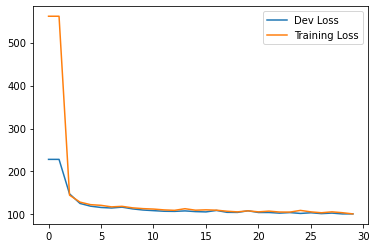

Epoch 30 Test: 100%|██████████| 10/10 [00:13<00:00,  1.32s/it]

Finished Training


In [17]:
%matplotlib inline

import matplotlib.pyplot as plt
from IPython import display

#Nombre del archivo de backup
savefile = 'best-model.pt'

epochs_without_change = 0
epochs = len(loss_per_epoch)

while epochs_without_change < stop_after_best:  # itero hasta que no mejore el desempeño en dev por 10 épocas
    display.clear_output(wait=True)
    print("###############################################")
    print("Current epoch: " + str(epochs))
    print("Last model save was in epoch " + str(last_epoch_save))
    print("Stopping training in: " + str(stop_after_best - epochs_without_change) + " epochs.")
    print("###############################################")
    print("[Best iter] training loss is: " + str(best_tl))
    print("[Best iter] dev loss is: " + str(best_l))
    print("###############################################")
    print("[Last iter] training loss was: " + str(training_loss[-1]))
    print("[Last iter] dev. loss was: " + str(loss_per_epoch[-1]))
    print("###############################################")
    
    #Dibujo lo que puedo
    plt.plot(range(epochs), loss_per_epoch)
    plt.plot(range(epochs), training_loss)
    plt.legend(["Dev Loss", "Training Loss"])
    plt.show()
    
    model.reg.train()
        
    training_loss_epoch = []
        
    for i, data in tqdm(enumerate(trn_dl, 0), desc=f'Epoch {epochs:2d} Train', total=len(trn_dl)):

        x, y_true = data
        
        x = x.to(device)
        y_true = y_true.to(device).float()
        
        y_pred = model(x)
        
        loss = criterion(y_pred, y_true)
        
        training_loss_epoch.append(loss.item())
        
        # vaciamos los gradientes
        optimizer.zero_grad()
        loss.backward()
        
        optimizer.step()

        #print("Batch "+ str(i+1) + " done.")
    tl = np.mean(training_loss_epoch) #Asumo lotes del mismo tamaño
    
    val_loss_epoch = []
    
    #evaluar el modelo
    model.reg.eval()
    
    with torch.no_grad():
        for data in tqdm(tst_dl, desc=f'Epoch {epochs:2d} Test', total=len(tst_dl)):
            
            x, y_true = data
            
            x = x.to(device)
            
            y_true = y_true.to(device).float()
            # computamos la predicción
            y_pred = model(x)
            # computamos la pérdida
            val_loss_epoch.append(criterion(y_pred, y_true).item())

    l = np.mean(val_loss_epoch)        
    
    epochs_without_change += 1
    if best_l is None or best_l >= l:
        torch.save(model, savefile)
        best_l = l
        best_tl = tl
        epochs_without_change = 0
        last_epoch_save = epochs
        print("Model improved, saved.")
    
    #Para graficar con una escala coherente.
    if(tl > worst_tl):
        worst_tl = tl
        training_loss[0] = worst_tl

    if(l > worst_l):
        worst_l = l
        loss_per_epoch[0] = worst_l
    #Rastreo las perdidas
    loss_per_epoch.append(l)
    training_loss.append(tl)
    #Rastreo la época actual
    epochs += 1
    sys.stdout.flush()
print('Finished Training')

## 5. Probando

In [18]:
model = torch.load(savefile)

model = model.to('cpu')

### 5.1 Evaluando en entrenamiento

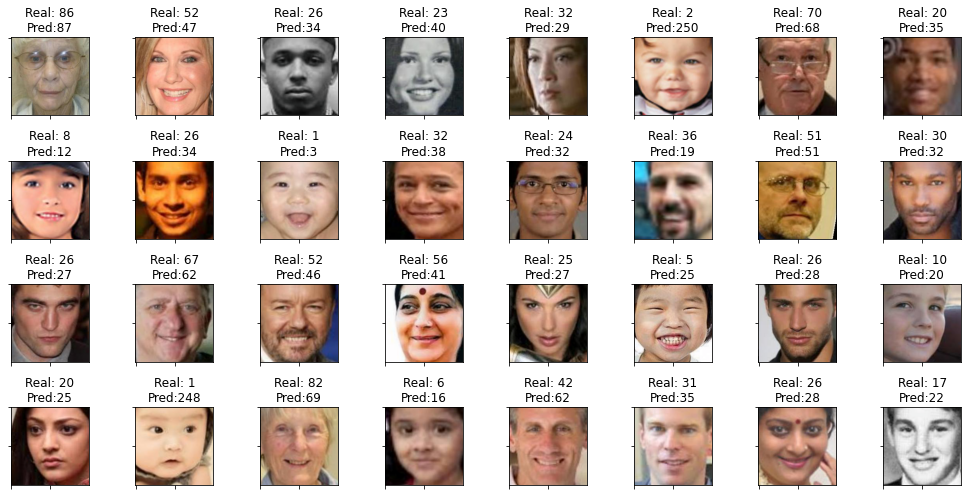

In [19]:
with torch.no_grad():
    x, y_true = next(iter(trn_dl))
    y_pred = model(x)
    display_batch(ROWS, COLS, x, y_true, y_pred)

### 5.2 Evaluando en prueba

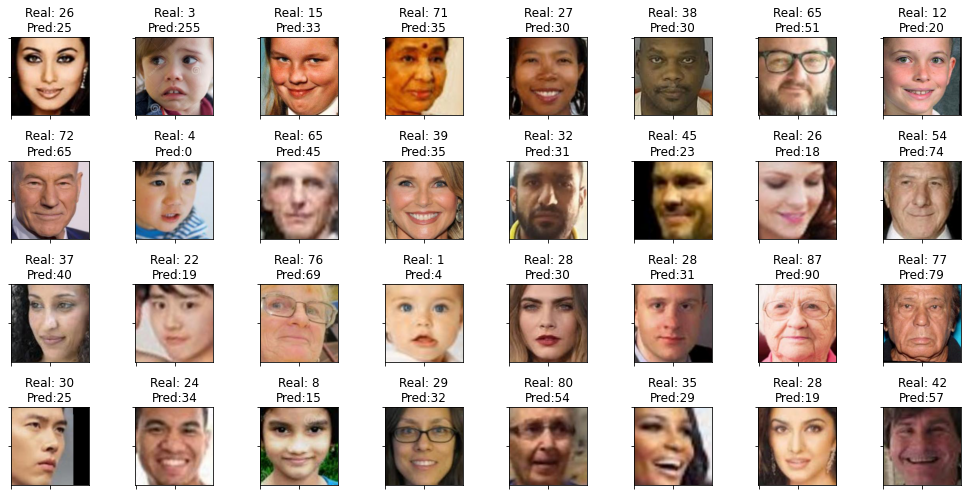

In [20]:
with torch.no_grad():
    x, y_true = next(iter(tst_dl))
    y_pred = model(x)
    display_batch(ROWS, COLS, x, y_true, y_pred)

Como se puede notar, hay buenos resultados por lo general. Desgraciadamente existen resultados con predicciones sumamente malas (fuera del rango posible de edad). Estos pueden resolverse haciendo uso de la teoría de los Modelos Lineales Generalizados utilizando una función liga.

Para este caso, agregaré una función sigmoide en la salida y la multiplicaré por la edad máxima en el dataset (116).

# Versión modificada de la arquitectura

In [10]:
class RegDenseNet(nn.Module):
    
    def __init__(self, pretrained):
        super(RegDenseNet, self).__init__()
        
        # cargamos el modelo
        self.cnn = tvm.densenet121(pretrained=pretrained)
        # remplazamos la FC para dejar intactas 
        # las características (diablito)
        self.cnn.classifier = nn.Identity()

        in_features = 1024
        # armamos la capa de regresión
        self.reg = nn.Sequential(
            nn.BatchNorm1d(in_features),
            nn.Linear(in_features, 1)
        )
    
    def forward(self, x):
        # [N, 3, 224, 224] => [N, 1024]
        x = self.cnn(x)
        # [N, 1024] => [N, 1]
        x = torch.squeeze(self.reg(x))
        x = torch.sigmoid(x) * 116 #Limita los valores de salida al rango posible de edades (0-116)
        return x

In [11]:
model = RegDenseNet(True)

# congelado de parámetros de la CNN
for param in model.cnn.parameters():
    param.requires_grad = False
# congelado de estadísticas de todo el modelo
_ = model.eval()

### 3.2 Inspección de la arquitectura

In [37]:
summary(model, (1, 3, IMG_SIZE, IMG_SIZE), device='cpu', verbose=0)

Layer (type:depth-idx)                   Output Shape              Param #
├─DenseNet: 1-1                          [1, 1024]                 --
|    └─Sequential: 2-1                   [1, 1024, 6, 6]           --
|    |    └─Conv2d: 3-1                  [1, 64, 100, 100]         (9,408)
|    |    └─BatchNorm2d: 3-2             [1, 64, 100, 100]         (128)
|    |    └─ReLU: 3-3                    [1, 64, 100, 100]         --
|    |    └─MaxPool2d: 3-4               [1, 64, 50, 50]           --
|    |    └─_DenseBlock: 3-5             [1, 256, 50, 50]          (335,040)
|    |    └─_Transition: 3-6             [1, 128, 25, 25]          (33,280)
|    |    └─_DenseBlock: 3-7             [1, 512, 25, 25]          (919,680)
|    |    └─_Transition: 3-8             [1, 256, 12, 12]          (132,096)
|    |    └─_DenseBlock: 3-9             [1, 1024, 12, 12]         (2,837,760)
|    |    └─_Transition: 3-10            [1, 512, 6, 6]            (526,336)
|    |    └─_DenseBlock: 3-11     

## 4 Entrenamiento

<!-- <img src="../figs/comida_entrenamiento.svg" width="650" height="450"> -->

In [40]:
# movemos el modelo 
model = model.to(device)
next(model.parameters()).device

device(type='cuda', index=0)

### 4.1 Ciclo de entrenamiento

In [41]:
criterion = F.mse_loss #nn.L1Loss()
optimizer = optim.Adam(model.parameters(), lr = 1e-2)

In [42]:
loss_per_epoch = [0]
training_loss = [0]
stop_after_best = 4
best_l = None
best_tl = None
worst_l = 0
worst_tl = 0
last_epoch_save = 0

###############################################
Current epoch: 14
Last model save was in epoch 10
Stopping training in: 1 epochs.
###############################################
[Best iter] training loss is: 117.5690867775365
[Best iter] dev loss is: 101.69159851074218
###############################################
[Last iter] training loss was: 106.86359154550652
[Last iter] dev. loss was: 104.87519226074218
###############################################


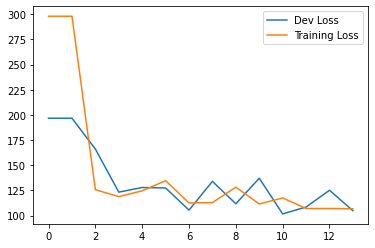

Epoch 14 Test: 100%|██████████| 10/10 [00:12<00:00,  1.27s/it]

Finished Training


In [43]:
%matplotlib inline

import matplotlib.pyplot as plt
from IPython import display

#Nombre del archivo de backup
savefile = 'best-model.pt'

epochs_without_change = 0
epochs = len(loss_per_epoch)

while epochs_without_change < stop_after_best:  # itero hasta que no mejore el desempeño en dev por 10 épocas
    display.clear_output(wait=True)
    print("###############################################")
    print("Current epoch: " + str(epochs))
    print("Last model save was in epoch " + str(last_epoch_save))
    print("Stopping training in: " + str(stop_after_best - epochs_without_change) + " epochs.")
    print("###############################################")
    print("[Best iter] training loss is: " + str(best_tl))
    print("[Best iter] dev loss is: " + str(best_l))
    print("###############################################")
    print("[Last iter] training loss was: " + str(training_loss[-1]))
    print("[Last iter] dev. loss was: " + str(loss_per_epoch[-1]))
    print("###############################################")
    
    #Dibujo lo que puedo
    plt.plot(range(epochs), loss_per_epoch)
    plt.plot(range(epochs), training_loss)
    plt.legend(["Dev Loss", "Training Loss"])
    plt.show()
    
    model.reg.train()
        
    training_loss_epoch = []
        
    for i, data in tqdm(enumerate(trn_dl, 0), desc=f'Epoch {epochs:2d} Train', total=len(trn_dl)):

        x, y_true = data
        
        x = x.to(device)
        y_true = y_true.to(device).float()
        
        y_pred = model(x)
        
        loss = criterion(y_pred, y_true)
        
        training_loss_epoch.append(loss.item())
        
        # vaciamos los gradientes
        optimizer.zero_grad()
        loss.backward()
        
        optimizer.step()

        #print("Batch "+ str(i+1) + " done.")
    tl = np.mean(training_loss_epoch) #Asumo lotes del mismo tamaño
    
    val_loss_epoch = []
    
    #evaluar el modelo
    model.reg.eval()
    
    with torch.no_grad():
        for data in tqdm(tst_dl, desc=f'Epoch {epochs:2d} Test', total=len(tst_dl)):
            
            x, y_true = data
            
            x = x.to(device)
            
            y_true = y_true.to(device).float()
            # computamos la predicción
            y_pred = model(x)
            # computamos la pérdida
            val_loss_epoch.append(criterion(y_pred, y_true).item())

    l = np.mean(val_loss_epoch)        
    
    epochs_without_change += 1
    if best_l is None or best_l >= l:
        torch.save(model, savefile)
        best_l = l
        best_tl = tl
        epochs_without_change = 0
        last_epoch_save = epochs
        print("Model improved, saved.")
    
    #Para graficar con una escala coherente.
    if(tl > worst_tl):
        worst_tl = tl
        training_loss[0] = worst_tl

    if(l > worst_l):
        worst_l = l
        loss_per_epoch[0] = worst_l
    #Rastreo las perdidas
    loss_per_epoch.append(l)
    training_loss.append(tl)
    #Rastreo la época actual
    epochs += 1
    sys.stdout.flush()
print('Finished Training')

## 5. Probando

In [44]:
model = torch.load(savefile)

model = model.to('cpu')

### 5.1 Evaluando en entrenamiento

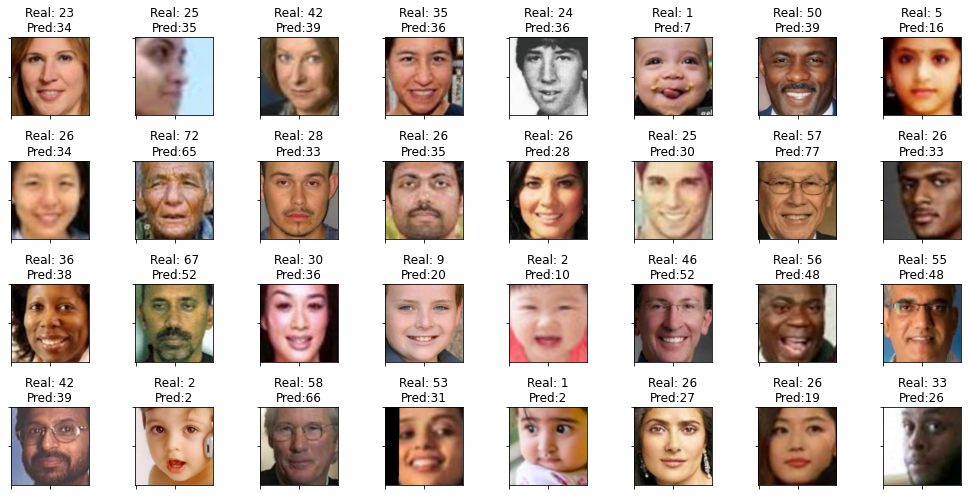

In [45]:
with torch.no_grad():
    x, y_true = next(iter(trn_dl))
    y_pred = model(x)
    display_batch(ROWS, COLS, x, y_true, y_pred)

### 5.2 Evaluando en prueba

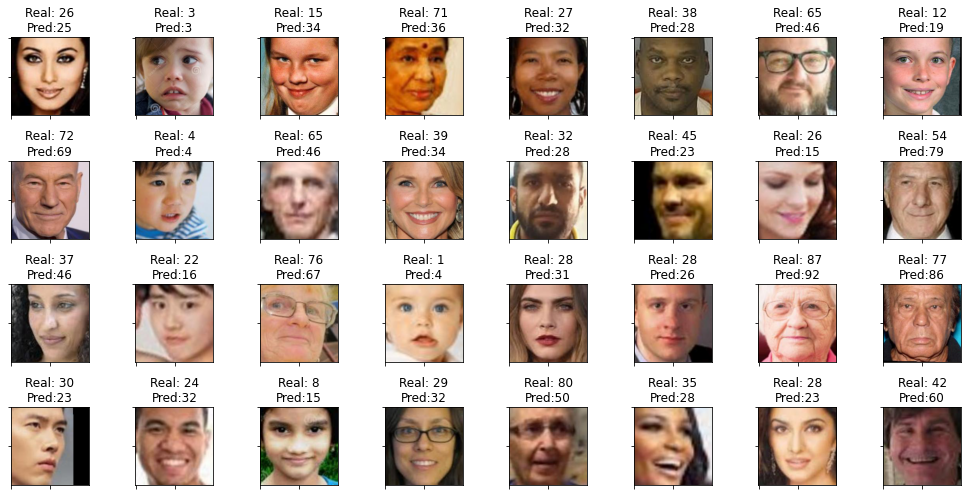

In [46]:
with torch.no_grad():
    x, y_true = next(iter(tst_dl))
    y_pred = model(x)
    display_batch(ROWS, COLS, x, y_true, y_pred)

Se notan resultados mucho más coherentes con el rango de edad posible. No obstante de eso, me gustaría intentar con una métrica distinta. La pérdida L1 podría dar resultados distintos en cuanto a las caras más difíciles de asignar edad. Esto es debido a que esta métrica suele ser menos sensible a los datos extremos.

#### Intentando otra función de pérdida (L1)

In [55]:
model = RegDenseNet(True)

# congelado de parámetros de la CNN
for param in model.cnn.parameters():
    param.requires_grad = False
# congelado de estadísticas de todo el modelo
_ = model.eval()

In [56]:
# movemos el modelo 
model = model.to(device)
next(model.parameters()).device

device(type='cuda', index=0)

In [57]:
criterion = nn.L1Loss()
optimizer = optim.Adam(model.parameters(), lr = 1e-2)

In [58]:
loss_per_epoch = [0]
training_loss = [0]
stop_after_best = 4
best_l = None
best_tl = None
worst_l = 0
worst_tl = 0
last_epoch_save = 0

###############################################
Current epoch: 26
Last model save was in epoch 22
Stopping training in: 1 epochs.
###############################################
[Best iter] training loss is: 7.618992441578915
[Best iter] dev loss is: 7.435471868515014
###############################################
[Last iter] training loss was: 7.696344225030196
[Last iter] dev. loss was: 8.19213285446167
###############################################


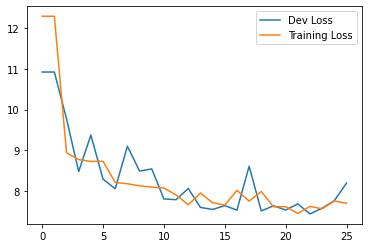

Epoch 26 Test: 100%|██████████| 10/10 [00:12<00:00,  1.28s/it]

Finished Training


In [59]:
%matplotlib inline

import matplotlib.pyplot as plt
from IPython import display

#Nombre del archivo de backup
savefile = 'best-model.pt'

epochs_without_change = 0
epochs = len(loss_per_epoch)

while epochs_without_change < stop_after_best:  # itero hasta que no mejore el desempeño en dev por 10 épocas
    display.clear_output(wait=True)
    print("###############################################")
    print("Current epoch: " + str(epochs))
    print("Last model save was in epoch " + str(last_epoch_save))
    print("Stopping training in: " + str(stop_after_best - epochs_without_change) + " epochs.")
    print("###############################################")
    print("[Best iter] training loss is: " + str(best_tl))
    print("[Best iter] dev loss is: " + str(best_l))
    print("###############################################")
    print("[Last iter] training loss was: " + str(training_loss[-1]))
    print("[Last iter] dev. loss was: " + str(loss_per_epoch[-1]))
    print("###############################################")
    
    #Dibujo lo que puedo
    plt.plot(range(epochs), loss_per_epoch)
    plt.plot(range(epochs), training_loss)
    plt.legend(["Dev Loss", "Training Loss"])
    plt.show()
    
    model.reg.train()
        
    training_loss_epoch = []
        
    for i, data in tqdm(enumerate(trn_dl, 0), desc=f'Epoch {epochs:2d} Train', total=len(trn_dl)):

        x, y_true = data
        
        x = x.to(device)
        y_true = y_true.to(device).float()
        
        y_pred = model(x)
        
        loss = criterion(y_pred, y_true)
        
        training_loss_epoch.append(loss.item())
        
        # vaciamos los gradientes
        optimizer.zero_grad()
        loss.backward()
        
        optimizer.step()

        #print("Batch "+ str(i+1) + " done.")
    tl = np.mean(training_loss_epoch) #Asumo lotes del mismo tamaño
    
    val_loss_epoch = []
    
    #evaluar el modelo
    model.reg.eval()
    
    with torch.no_grad():
        for data in tqdm(tst_dl, desc=f'Epoch {epochs:2d} Test', total=len(tst_dl)):
            
            x, y_true = data
            
            x = x.to(device)
            
            y_true = y_true.to(device).float()
            # computamos la predicción
            y_pred = model(x)
            # computamos la pérdida
            val_loss_epoch.append(criterion(y_pred, y_true).item())

    l = np.mean(val_loss_epoch)        
    
    epochs_without_change += 1
    if best_l is None or best_l >= l:
        torch.save(model, savefile)
        best_l = l
        best_tl = tl
        epochs_without_change = 0
        last_epoch_save = epochs
        print("Model improved, saved.")
    
    #Para graficar con una escala coherente.
    if(tl > worst_tl):
        worst_tl = tl
        training_loss[0] = worst_tl

    if(l > worst_l):
        worst_l = l
        loss_per_epoch[0] = worst_l
    #Rastreo las perdidas
    loss_per_epoch.append(l)
    training_loss.append(tl)
    #Rastreo la época actual
    epochs += 1
    sys.stdout.flush()
print('Finished Training')

In [60]:
model = torch.load(savefile)

model = model.to('cpu')

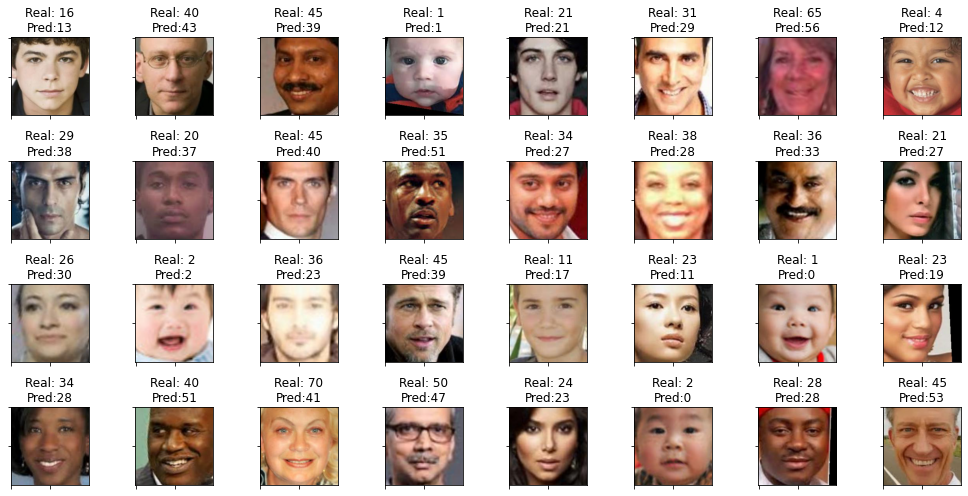

In [61]:
with torch.no_grad():
    x, y_true = next(iter(trn_dl))
    y_pred = model(x)
    display_batch(ROWS, COLS, x, y_true, y_pred)

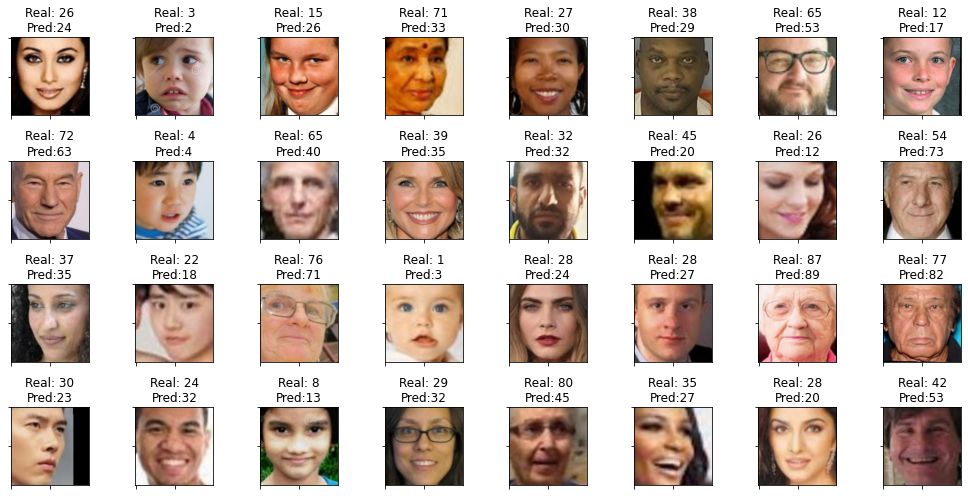

In [62]:
with torch.no_grad():
    x, y_true = next(iter(tst_dl))
    y_pred = model(x)
    display_batch(ROWS, COLS, x, y_true, y_pred)

Por lo general los resultados no parecen muy malos. Existen algunos casos en que la predicción es bastante distante, pero por lo menos acierta en lo que yo llamaría el "rango de edad" (joven, adulto, anciano). En varios casos en los que la red falla incluso en esto, puedo ver que las imágenes son poco claras.

# Reentrenando toda la red

In [30]:
model = RegDenseNet(True)

# movemos el modelo 
model = model.to(device)
next(model.parameters()).device

device(type='cuda', index=0)

In [31]:
criterion = F.mse_loss
optimizer = optim.Adam(model.parameters(), lr = 1e-2)

In [32]:
loss_per_epoch = [0]
training_loss = [0]
stop_after_best = 10
best_l = None
best_tl = None
worst_l = 0
worst_tl = 0
last_epoch_save = 0

###############################################
Current epoch: 51
Last model save was in epoch 41
Stopping training in: 1 epochs.
###############################################
[Best iter] training loss is: 72.61505797415069
[Best iter] dev loss is: 76.97529663085938
###############################################
[Last iter] training loss was: 58.744251495258574
[Last iter] dev. loss was: 96.01530481974284
###############################################


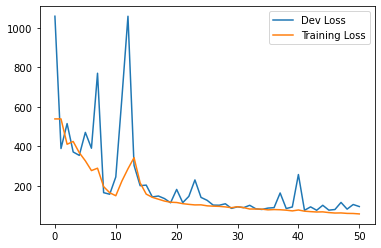

Epoch 51 Test: 100%|██████████| 75/75 [00:11<00:00,  6.55it/s]

Finished Training


In [33]:
%matplotlib inline

import matplotlib.pyplot as plt
from IPython import display

#Nombre del archivo de backup
savefile = 'best-model.pt'

epochs_without_change = 0
epochs = len(loss_per_epoch)

while epochs_without_change < stop_after_best:  # itero hasta que no mejore el desempeño en dev por 10 épocas
    display.clear_output(wait=True)
    print("###############################################")
    print("Current epoch: " + str(epochs))
    print("Last model save was in epoch " + str(last_epoch_save))
    print("Stopping training in: " + str(stop_after_best - epochs_without_change) + " epochs.")
    print("###############################################")
    print("[Best iter] training loss is: " + str(best_tl))
    print("[Best iter] dev loss is: " + str(best_l))
    print("###############################################")
    print("[Last iter] training loss was: " + str(training_loss[-1]))
    print("[Last iter] dev. loss was: " + str(loss_per_epoch[-1]))
    print("###############################################")
    
    #Dibujo lo que puedo
    plt.plot(range(epochs), loss_per_epoch)
    plt.plot(range(epochs), training_loss)
    plt.legend(["Dev Loss", "Training Loss"])
    plt.show()
    
    model.train()
        
    training_loss_epoch = []
        
    for i, data in tqdm(enumerate(trn_dl, 0), desc=f'Epoch {epochs:2d} Train', total=len(trn_dl)):

        x, y_true = data
        
        x = x.to(device)
        y_true = y_true.to(device).float()
        
        y_pred = model(x)
        
        loss = criterion(y_pred, y_true)
        
        training_loss_epoch.append(loss.item())
        
        # vaciamos los gradientes
        optimizer.zero_grad()
        loss.backward()
        
        optimizer.step()

        #print("Batch "+ str(i+1) + " done.")
    tl = np.mean(training_loss_epoch) #Asumo lotes del mismo tamaño
    
    val_loss_epoch = []
    
    #evaluar el modelo
    model.eval()
    
    with torch.no_grad():
        for data in tqdm(tst_dl, desc=f'Epoch {epochs:2d} Test', total=len(tst_dl)):
            
            x, y_true = data
            
            x = x.to(device)
            
            y_true = y_true.to(device).float()
            # computamos la predicción
            y_pred = model(x)
            # computamos la pérdida
            val_loss_epoch.append(criterion(y_pred, y_true).item())

    l = np.mean(val_loss_epoch)        
    
    epochs_without_change += 1
    if best_l is None or best_l >= l:
        torch.save(model, savefile)
        best_l = l
        best_tl = tl
        epochs_without_change = 0
        last_epoch_save = epochs
        print("Model improved, saved.")
    
    #Para graficar con una escala coherente.
    if(tl > worst_tl):
        worst_tl = tl
        training_loss[0] = worst_tl

    if(l > worst_l):
        worst_l = l
        loss_per_epoch[0] = worst_l
    #Rastreo las perdidas
    loss_per_epoch.append(l)
    training_loss.append(tl)
    #Rastreo la época actual
    epochs += 1
    sys.stdout.flush()
print('Finished Training')

In [34]:
model = torch.load(savefile)

model = model.to('cpu')

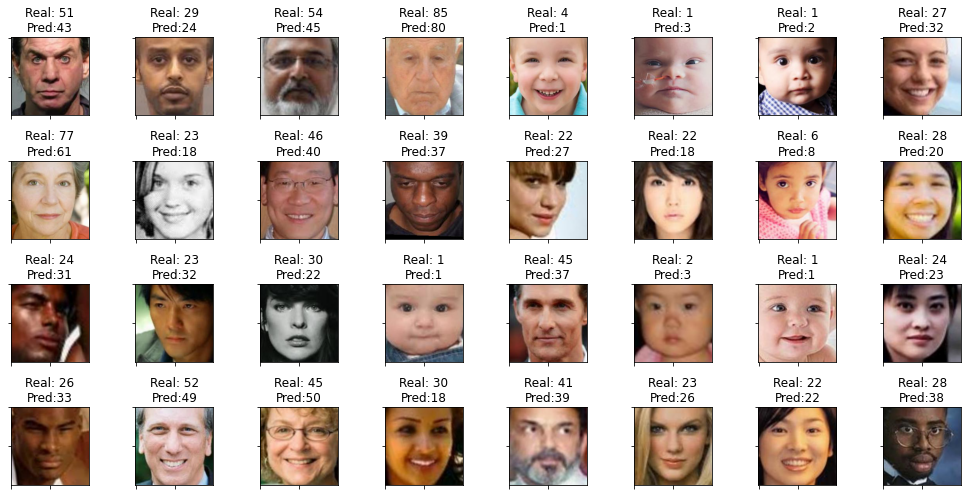

In [35]:
with torch.no_grad():
    x, y_true = next(iter(trn_dl))
    y_pred = model(x)
    display_batch(ROWS, COLS, x, y_true, y_pred)

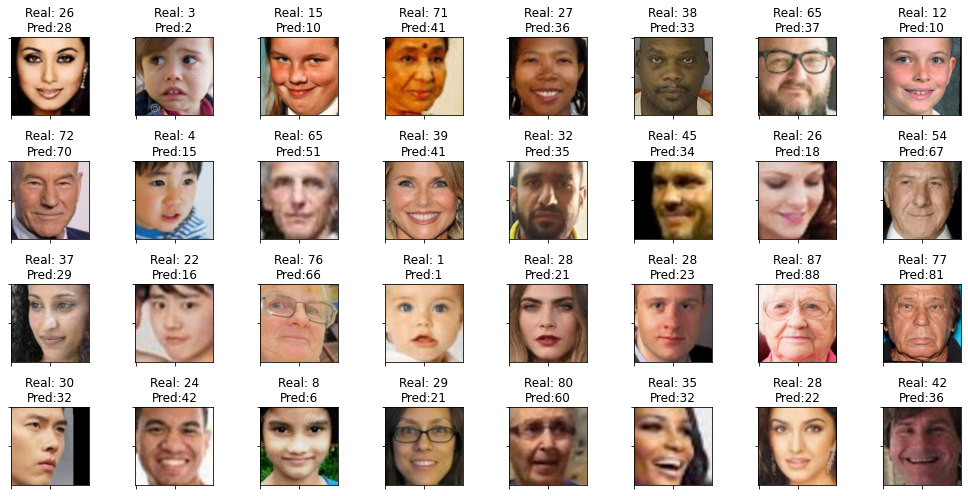

In [36]:
with torch.no_grad():
    x, y_true = next(iter(tst_dl))
    y_pred = model(x)
    display_batch(ROWS, COLS, x, y_true, y_pred)

## Probando con pérdida L1

In [37]:
model = RegDenseNet(True)

# movemos el modelo 
model = model.to(device)
next(model.parameters()).device

device(type='cuda', index=0)

In [38]:
criterion = nn.L1Loss()
optimizer = optim.Adam(model.parameters(), lr = 1e-2)

In [39]:
loss_per_epoch = [0]
training_loss = [0]
stop_after_best = 10
best_l = None
best_tl = None
worst_l = 0
worst_tl = 0
last_epoch_save = 0

###############################################
Current epoch: 67
Last model save was in epoch 57
Stopping training in: 1 epochs.
###############################################
[Best iter] training loss is: 5.312012262215919
[Best iter] dev loss is: 5.877873935699463
###############################################
[Last iter] training loss was: 5.1325831220607565
[Last iter] dev. loss was: 6.68967726389567
###############################################


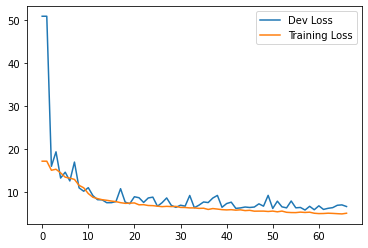

Epoch 67 Test: 100%|██████████| 75/75 [00:11<00:00,  6.57it/s]

Finished Training


In [40]:
%matplotlib inline

import matplotlib.pyplot as plt
from IPython import display

#Nombre del archivo de backup
savefile = 'best-model.pt'

epochs_without_change = 0
epochs = len(loss_per_epoch)

while epochs_without_change < stop_after_best:  # itero hasta que no mejore el desempeño en dev por 10 épocas
    display.clear_output(wait=True)
    print("###############################################")
    print("Current epoch: " + str(epochs))
    print("Last model save was in epoch " + str(last_epoch_save))
    print("Stopping training in: " + str(stop_after_best - epochs_without_change) + " epochs.")
    print("###############################################")
    print("[Best iter] training loss is: " + str(best_tl))
    print("[Best iter] dev loss is: " + str(best_l))
    print("###############################################")
    print("[Last iter] training loss was: " + str(training_loss[-1]))
    print("[Last iter] dev. loss was: " + str(loss_per_epoch[-1]))
    print("###############################################")
    
    #Dibujo lo que puedo
    plt.plot(range(epochs), loss_per_epoch)
    plt.plot(range(epochs), training_loss)
    plt.legend(["Dev Loss", "Training Loss"])
    plt.show()
    
    model.train()
        
    training_loss_epoch = []
        
    for i, data in tqdm(enumerate(trn_dl, 0), desc=f'Epoch {epochs:2d} Train', total=len(trn_dl)):

        x, y_true = data
        
        x = x.to(device)
        y_true = y_true.to(device).float()
        
        y_pred = model(x)
        
        loss = criterion(y_pred, y_true)
        
        training_loss_epoch.append(loss.item())
        
        # vaciamos los gradientes
        optimizer.zero_grad()
        loss.backward()
        
        optimizer.step()

        #print("Batch "+ str(i+1) + " done.")
    tl = np.mean(training_loss_epoch) #Asumo lotes del mismo tamaño
    
    val_loss_epoch = []
    
    #evaluar el modelo
    model.eval()
    
    with torch.no_grad():
        for data in tqdm(tst_dl, desc=f'Epoch {epochs:2d} Test', total=len(tst_dl)):
            
            x, y_true = data
            
            x = x.to(device)
            
            y_true = y_true.to(device).float()
            # computamos la predicción
            y_pred = model(x)
            # computamos la pérdida
            val_loss_epoch.append(criterion(y_pred, y_true).item())

    l = np.mean(val_loss_epoch)        
    
    epochs_without_change += 1
    if best_l is None or best_l >= l:
        torch.save(model, savefile)
        best_l = l
        best_tl = tl
        epochs_without_change = 0
        last_epoch_save = epochs
        print("Model improved, saved.")
    
    #Para graficar con una escala coherente.
    if(tl > worst_tl):
        worst_tl = tl
        training_loss[0] = worst_tl

    if(l > worst_l):
        worst_l = l
        loss_per_epoch[0] = worst_l
    #Rastreo las perdidas
    loss_per_epoch.append(l)
    training_loss.append(tl)
    #Rastreo la época actual
    epochs += 1
    sys.stdout.flush()
print('Finished Training')

In [41]:
model = torch.load(savefile)

model = model.to('cpu')

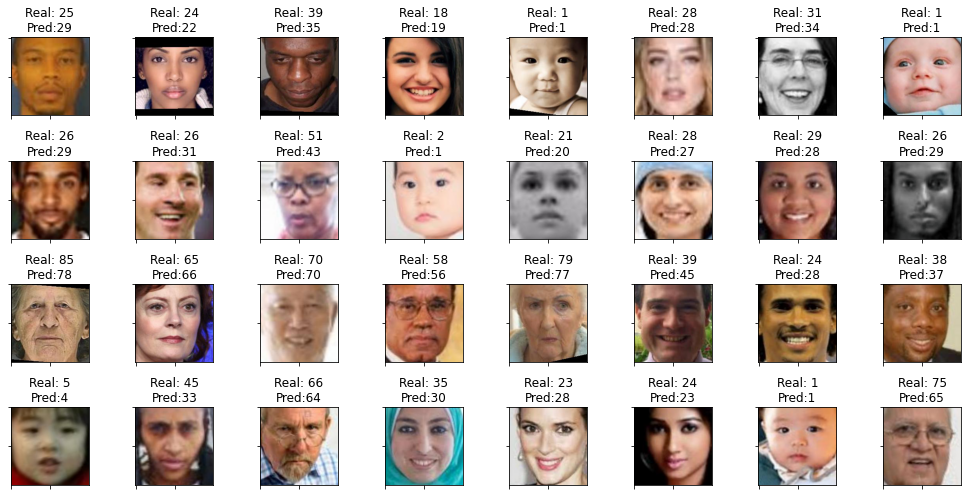

In [42]:
with torch.no_grad():
    x, y_true = next(iter(trn_dl))
    y_pred = model(x)
    display_batch(ROWS, COLS, x, y_true, y_pred)

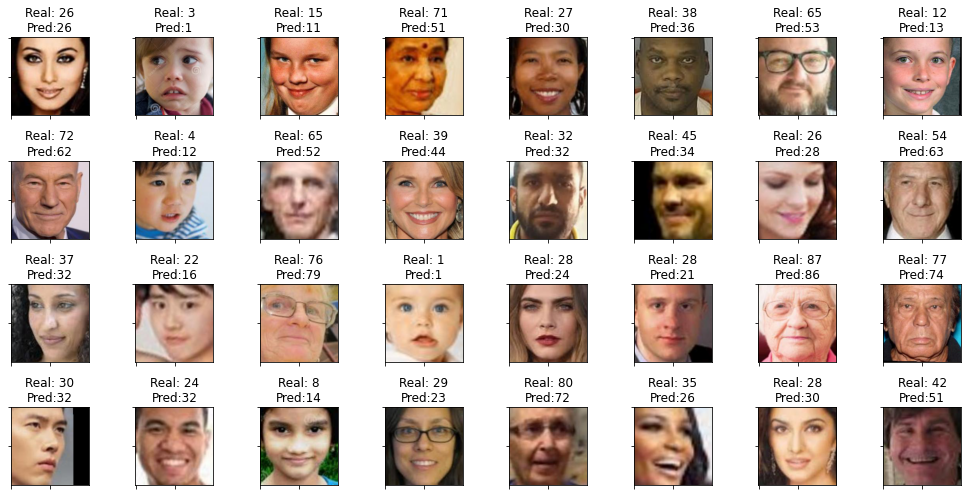

In [43]:
with torch.no_grad():
    x, y_true = next(iter(tst_dl))
    y_pred = model(x)
    display_batch(ROWS, COLS, x, y_true, y_pred)

### Análisis:

Por lo general, parece que se puede tener una buena aproximación a solucionar el problema con las dos formas en la que se resolvió. No obstante, creo que los mejores resultados son sin duda los proporcionados por la red completamente reentrenada. Esto puede deberse a que las representaciones que se aprenden en las últimas capas se modifican para que estas tengan una representación más directa de la edad en una cara.

Como todo modelo de ML, existen outliers y casos en los que no funciona tan bien. No obstante de esto, las densenet completamente reentrenadas (y en partícular aquella reentrenada con la pérdida L1) parecen tener un desempeño bastante bueno en el problema. Los casos en los que las predicciones difieren mucho de los valores reales por lo general me resultan difíciles de discernir incluso a mi.

Creo que en este caso, la combinación del early-stopping y la aumentación de datos permitieron que la red tuviera la cantidad de entrenamiento correcta para abarcar el problema.